# **Let's Identify Spam Email!**

### Have you ever thought how gmail, yahoo, outlook etc are filtering out the spam emails from your recieved emails? 

#### Well, they use machine learning algorithms for this. As we want to know if an email is spam or not, so we are gonna use binary classifier algorithm. 

To sove this problem we will try to understand the problems and solve it step by step.

In [70]:
# All the required libraries 
import google.colab
import os
import tarfile
import urllib.request
import email
import email.policy
from collections import Counter
import numpy as np
from sklearn.model_selection import train_test_split
import re
from html import unescape
import nltk
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import urlextract
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.sparse import csr_matrix
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score

#### **Step 1: Fetch the Data**

In [2]:
URL_ROOT = "http://spamassassin.apache.org/old/publiccorpus/"
HAM_URL = URL_ROOT + "20030228_easy_ham.tar.bz2"
SPAM_URL = URL_ROOT + "20030228_spam.tar.bz2"
SPAM_PATH = os.path.join("Dataset", "Spams")

def fetch_spam_data(ham_url=HAM_URL, spam_url=SPAM_URL, spam_path=SPAM_PATH):
    if not os.path.isdir(spam_path):
        os.makedirs(spam_path)
    for filename, url in (("ham.tar.bz2", ham_url), ("spam.tar.bz2", spam_url)):
        path = os.path.join(spam_path, filename)
        if not os.path.isfile(path):
            urllib.request.urlretrieve(url, path)
        tar_file = tarfile.open(path)
        tar_file.extractall(path=spam_path)
        tar_file.close()

In [9]:
# Now load all data and emails
fetch_spam_data()
HAM_DIR = os.path.join(SPAM_PATH, "easy_ham")
SPAM_DIR = os.path.join(SPAM_PATH, "spam")
ham_filenames = [name for name in sorted(os.listdir(HAM_DIR))if len(name) > 20]
spam_filenames = [name for name in sorted(os.listdir(SPAM_DIR)) if len(name) > 20]

In [10]:
len(ham_filenames), len(spam_filenames)

(2500, 500)

In [12]:
# A function to parse all the emails we have loaded. We are using Python's library email to do this.
# What it actually does is that, it labels the data present from an actual email.
# We need to break the whole email into different segments like: from, to, body, date etc. This library helps us to do that.
def parse_email(is_spam, filename, spam_path=SPAM_PATH):
    directory = "spam" if is_spam else "easy_ham"
    with open(os.path.join(spam_path, directory, filename), "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

In [13]:
ham_emails = [parse_email(is_spam=False, filename=name) for name in ham_filenames]
spam_emails = [parse_email(is_spam=True, filename=name) for name in spam_filenames]

#### **Step 2: Understanding the Data**

There are many contents in a sigle email. We need to understand those contents so that we can use them as labels and train our model to classigy based on each content.

In [18]:
def get_email_content(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        return "multipart({})".format(", ".join([
            get_email_content(sub_email)
            for sub_email in payload
        ]))
    else:
        return email.get_content_type()

In [19]:
# Now let's use counter library to count the contents of each email.
def content_counter(emails):
    contents = Counter()
    for email in emails:
        content = get_email_content(email)
        contents[content] += 1
    return contents

In [20]:
content_counter(ham_emails).most_common()

[('text/plain', 2408),
 ('multipart(text/plain, application/pgp-signature)', 66),
 ('multipart(text/plain, text/html)', 8),
 ('multipart(text/plain, text/plain)', 4),
 ('multipart(text/plain)', 3),
 ('multipart(text/plain, application/octet-stream)', 2),
 ('multipart(text/plain, text/enriched)', 1),
 ('multipart(text/plain, application/ms-tnef, text/plain)', 1),
 ('multipart(multipart(text/plain, text/plain, text/plain), application/pgp-signature)',
  1),
 ('multipart(text/plain, video/mng)', 1),
 ('multipart(text/plain, multipart(text/plain))', 1),
 ('multipart(text/plain, application/x-pkcs7-signature)', 1),
 ('multipart(text/plain, multipart(text/plain, text/plain), text/rfc822-headers)',
  1),
 ('multipart(text/plain, multipart(text/plain, text/plain), multipart(multipart(text/plain, application/x-pkcs7-signature)))',
  1),
 ('multipart(text/plain, application/x-java-applet)', 1)]

In [21]:
content_counter(spam_emails).most_common()

[('text/plain', 218),
 ('text/html', 183),
 ('multipart(text/plain, text/html)', 45),
 ('multipart(text/html)', 20),
 ('multipart(text/plain)', 19),
 ('multipart(multipart(text/html))', 5),
 ('multipart(text/plain, image/jpeg)', 3),
 ('multipart(text/html, application/octet-stream)', 2),
 ('multipart(text/plain, application/octet-stream)', 1),
 ('multipart(text/html, text/plain)', 1),
 ('multipart(multipart(text/html), application/octet-stream, image/jpeg)', 1),
 ('multipart(multipart(text/plain, text/html), image/gif)', 1),
 ('multipart/alternative', 1)]

We can see that most of the ham_emails are plain text and signed. But in case of spam_emails, none of the emails are signed and most of them are html.

If you want to understand the data more then you can print out by using index.

#### **Step 3: Procressing the Data**

In [24]:
X = np.array(ham_emails + spam_emails, dtype=object)

# We will set 0 for all the ham_emails and 1 for all the spam_emails and make an array of those zeros and ones.
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
X

array([<email.message.EmailMessage object at 0x7fd9ee785110>,
       <email.message.EmailMessage object at 0x7fd9ee785250>, ...,
      dtype=object)

In [27]:
y

array([0, 0, 0, ..., 1, 1, 1])

Now we will convert the html data into plain text so that we can train them too. For that we are using regex function here as we know the data structure. But there are some other dependencies: BeautifulSoup, html2text etc that can also be used.

In [30]:
# unescape is used to remove html entities (such as &gt; or &nbsp;)
def html_to_plain_text(html):
    text = re.sub('<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I)
    text = re.sub('<a\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I)
    text = re.sub('<.*?>', '', text, flags=re.M | re.S)
    text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S)
    return unescape(text)


To check if we are doing the conversion correctly or not, let's print html text first and then the converted text!

In [73]:
html_spam_emails = [email for email in X_train[y_train==1] if get_email_content(email) == "text/html"]
random_html_spam = html_spam_emails[7]
print(random_html_spam.get_content().strip()[:1500])

<HTML><HEAD><TITLE></TITLE><META http-equiv="Content-Type" content="text/html; charset=windows-1252"><STYLE>A:link {TEX-DECORATION: none}A:active {TEXT-DECORATION: none}A:visited {TEXT-DECORATION: none}A:hover {COLOR: #0033ff; TEXT-DECORATION: underline}</STYLE><META content="MSHTML 6.00.2713.1100" name="GENERATOR"></HEAD>
<BODY text="#000000" vLink="#0033ff" link="#0033ff" bgColor="#CCCC99"><TABLE borderColor="#660000" cellSpacing="0" cellPadding="0" border="0" width="100%"><TR><TD bgColor="#CCCC99" valign="top" colspan="2" height="27">
<font size="6" face="Arial, Helvetica, sans-serif" color="#660000">
<b>OTC</b></font></TD></TR><TR><TD height="2" bgcolor="#6a694f">
<font size="5" face="Times New Roman, Times, serif" color="#FFFFFF">
<b>&nbsp;Newsletter</b></font></TD><TD height="2" bgcolor="#6a694f"><div align="right"><font color="#FFFFFF">
<b>Discover Tomorrow's Winners&nbsp;</b></font></div></TD></TR><TR><TD height="25" colspan="2" bgcolor="#CCCC99"><table width="100%" border="0" 

Now let's visualize the plain text data. We will be using wordcloud library to show maximum used words in a spam email.

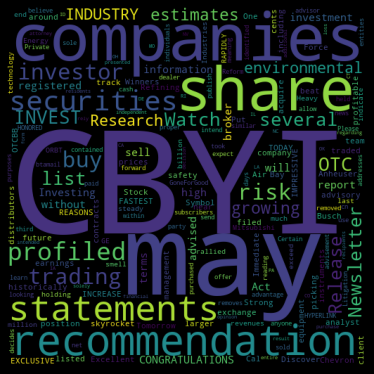

In [95]:
spam_words = html_to_plain_text(random_html_spam.get_content())
spam_wc = WordCloud(width=512, height=512).generate(spam_words)
plt.figure(figsize=(5,5),facecolor="k")
plt.imshow(spam_wc)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

Now let's add these two functions into one so that it takes an email and converts it as a plain text!

In [35]:
def email_to_text(email):
    html = None
    for part in email.walk(): # walk() function iterates over the email where is_multipart is true
        ctype = part.get_content_type()
        if not ctype in ("text/plain", "text/html"):
            continue
        try:
            content = part.get_content()
        except: # in case of encoding issues
            content = str(part.get_payload())
        if ctype == "text/plain":
            return content
        else:
            html = content
    if html:
        return html_to_plain_text(html)

In [36]:
print(email_to_text(random_html_spam)[:500])



OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Watch for analyst "Strong Buy Recommendations" and several advisory newsletters picking CBYI.  CBYI has filed to be traded on the OTCBB, share prices historically INCREASE when companies get listed on this larger trading exchange. CBYI is trading around 25 cents and should skyrocket to $2.66 - $3.25 a share in the near future.
Put CBYI on your watch list, acquire a position TODAY.
REASONS TO INVEST I


Now we use prepare the natural language stems using which we will detect if an email is spam or not!

In [46]:
stem = nltk.PorterStemmer()
url_extractor = urlextract.URLExtract()


Now we will create a transformer class to fully procress the plain text of the emails. So that we can then train our models on those processed words!

In [51]:
class EmailToWordTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, lower_case=True, remove_punctuation=True,
                 replace_urls=True, replace_numbers=True, stemming=True):
        self.lower_case = lower_case
        self.remove_punctuation = remove_punctuation
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.stemming = stemming
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_transformed = []
        for email in X:
            text = email_to_text(email) or ""
            if self.lower_case:
                text = text.lower()

            if self.replace_urls and url_extractor is not None:
                urls = list(set(url_extractor.find_urls(text)))
                urls.sort(key=lambda url: len(url), reverse=True)
                for url in urls:
                    text = text.replace(url, " URL ")

            if self.replace_numbers:
                text = re.sub(r'\d+(?:\.\d*)?(?:[eE][+-]?\d+)?', 'NUMBER', text)

            if self.remove_punctuation:
                text = re.sub(r'\W+', ' ', text, flags=re.M)
            
            word_counts = Counter(text.split())

            if self.stemming and stem is not None:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = stem.stem(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            X_transformed.append(word_counts)
        return np.array(X_transformed)

In [52]:
check_x = X_train[:2]
words_from_check = EmailToWordTransformer().fit_transform(check_x)
words_from_check

array([Counter({'chuck': 1, 'murcko': 1, 'wrote': 1, 'stuff': 1, 'yawn': 1, 'r': 1}),
       Counter({'the': 11, 'of': 9, 'and': 8, 'all': 3, 'christian': 3, 'to': 3, 'by': 3, 'jefferson': 2, 'i': 2, 'have': 2, 'superstit': 2, 'one': 2, 'on': 2, 'been': 2, 'ha': 2, 'half': 2, 'rogueri': 2, 'teach': 2, 'jesu': 2, 'some': 1, 'interest': 1, 'quot': 1, 'url': 1, 'thoma': 1, 'examin': 1, 'known': 1, 'word': 1, 'do': 1, 'not': 1, 'find': 1, 'in': 1, 'our': 1, 'particular': 1, 'redeem': 1, 'featur': 1, 'they': 1, 'are': 1, 'alik': 1, 'found': 1, 'fabl': 1, 'mytholog': 1, 'million': 1, 'innoc': 1, 'men': 1, 'women': 1, 'children': 1, 'sinc': 1, 'introduct': 1, 'burnt': 1, 'tortur': 1, 'fine': 1, 'imprison': 1, 'what': 1, 'effect': 1, 'thi': 1, 'coercion': 1, 'make': 1, 'world': 1, 'fool': 1, 'other': 1, 'hypocrit': 1, 'support': 1, 'error': 1, 'over': 1, 'earth': 1, 'six': 1, 'histor': 1, 'american': 1, 'john': 1, 'e': 1, 'remsburg': 1, 'letter': 1, 'william': 1, 'short': 1, 'again': 1, 'becom

Until now everything looks good enough! Now we will convert these words into a vector.

In [60]:
class WordToVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size
    def fit(self, X, y=None):
        total_count = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_count[word] += min(count, 10)
        most_common = total_count.most_common()[:self.vocabulary_size]
        self.vocabulary_ = {word: index + 1 for index, (word, count) in enumerate(most_common)}
        return self
    def transform(self, X, y=None):
        rows = []
        cols = []
        data = []
        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                rows.append(row)
                cols.append(self.vocabulary_.get(word, 0))
                data.append(count)
        return csr_matrix((data, (rows, cols)), shape=(len(X), self.vocabulary_size +1))

In [61]:
vocab_transformer = WordToVectorTransformer(vocabulary_size=10)
X_few_vectors = vocab_transformer.fit_transform(words_from_check)
X_few_vectors.toarray()

array([[ 6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [97, 11,  9,  8,  3,  3,  3,  3,  2,  2,  2]], dtype=int64)


What does this matrix mean? Well, the 97 in the second row, first column, means that the second email contains 97 words that are not part of the vocabulary. The 11 next to it means that the first word in the vocabulary is present 11 times in this email. The 9 next to it means that the second word is present 9 times, and so on.

#### **Step 4: Pipeline for Data Procressing**

At this point you already understood the struggle is mainly in the data procressing part. That's why we AI Engineers love to make pipelines for the whole data procressing workflow. That makes easier for us to procress a raw data with just one line of code. 

In [63]:
pipeline = Pipeline([
    ("email_to_word", EmailToWordTransformer()),
    ("word_to_vector", WordToVectorTransformer()),
])

X_train_transformed = pipeline.fit_transform(X_train) # We have processed our whole training data with just one line of code!

#### **Step 5: Train Your Model**

We will use the logistic regression for this model

In [68]:
classifier = LogisticRegression(solver="lbfgs", max_iter=1000, random_state=42)
score = cross_val_score(classifier, X_train_transformed, y_train, cv=3, verbose=3, scoring="accuracy")
score

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] .................................... , score=0.981, total=   0.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] .................................... , score=0.984, total=   0.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[CV] .................................... , score=0.991, total=   0.5s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.0s finished


array([0.98125, 0.98375, 0.99125])

So we have got a 98% accuracy score here! This is really amazing. Now we will test our unseen data with this model.

#### **Step 6: Test Your Model**

In [69]:

X_test_transformed = pipeline.transform(X_test)
classifier.fit(X_train_transformed, y_train)
y_pred = classifier.predict(X_test_transformed)

print("Accuracy: {:.2f}%".format(100 * cross_val_score(classifier, X_test_transformed, y_pred, cv=3, verbose=3, scoring="accuracy").mean()))
print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_pred)))
print("F1 Score: {:.2f}%".format(100 * f1_score(y_test, y_pred)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  ................................................................
[CV] .................................... , score=0.985, total=   0.2s
[CV]  ................................................................
[CV] .................................... , score=0.950, total=   0.2s
[CV]  ................................................................
[CV] .................................... , score=0.975, total=   0.1s
Accuracy: 97.00%
Precision: 95.88%
Recall: 97.89%
F1 Score: 96.88%


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s finished


## **The End**